In [23]:
import pandas as pd
import math
import matplotlib.pyplot as plt 

In [26]:
df = pd.read_csv("transaction_dataset.csv")

In [27]:
total = df.shape[0]
total_frauds = df["FLAG"].sum()

### fraud distribution of the dataset

transaction amount 9841
fraud amount 2179
the percentage of total frauds is 22.14 %


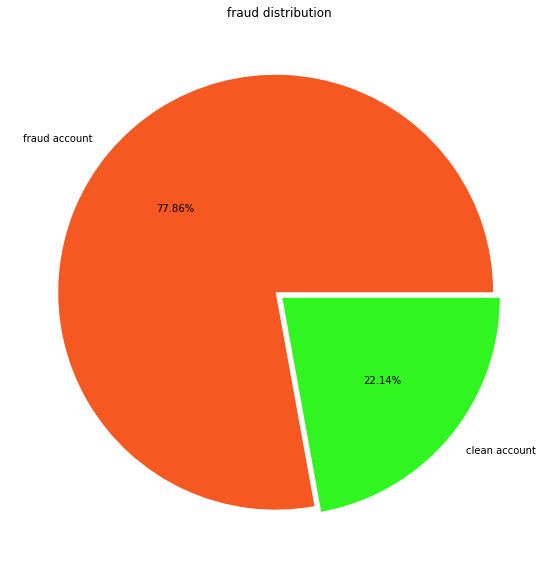

In [33]:
print("transaction amount " + str(total) + "\n" "fraud amount " + str(total_frauds))
print("the percentage of total frauds is " + str(round(total_frauds / total, 4) * 100) + " %")

pie, ax = plt.subplots(figsize=[15,10])
labels = ['fraud account', 'clean account']
colors = ['#F55821', '#31F521']
plt.pie(x = df['FLAG'].value_counts(), labels = labels, colors = colors, explode=[0.02] * 2,  autopct='%.2f%%')
plt.title('fraud distribution')
plt.show()

### facts about average transaction values, amounts, connections etc